## Load the model

In [1]:
%matplotlib widget
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import numpy as np
import pandas as pd
from pathcal.calculator import *
from pathcal.loader import *
from pathcal.layers import * 
from pathcal.helper import *

In [2]:
exp = load_expriment()

GPU AVAILABLE
GPU AVAILABLE
Logging results to results/20220211-152909-T06G-LeNet


Val -1/30: 100%|███████████████████████████████████| 79/79 [00:04<00:00, 18.52it/s, loss=0.018, top1=0.0882, top5=0.468]


In [3]:
compression_rates = [4, 10, 20, 30, 40, 50]
models = [i for i in range(1)]

In [4]:
def cal_linear_neurons(prev_paths, weights, threshold=0):
    next_path = torch.tile(prev_paths, (weights.size()[0],)).reshape(weights.size())
    next_path[weights.abs() <= threshold] = 0
    next_path = next_path.sum(axis=-1)
    return next_path, (next_path == 0).sum().item(), weights.sum(axis=-1)[next_path == 0].tolist()

def cal_conv_neurons(prev_paths, weights, threshold=0):
    # Calculate paths at current layer
    cur_path = weights.reshape(len(weights),-1)
    zero_n =  weights.reshape(len(weights),-1).sum(axis=-1)
    cur_path = (cur_path.abs() <= threshold).sum(axis=-1)
    # Calculate sum of all previous paths
    if prev_paths == None:
        total_prev_paths = 1
    else: 
        total_prev_paths = prev_paths.sum()
    # Calculate next paths
    next_path = cur_path * total_prev_paths
    return next_path, (next_path == 0).sum().item(), zero_n[next_path == 0].tolist()

In [8]:
paths = {}
isPos = False

#blockPrint()
for c in compression_rates:
    temp_path = torch.zeros((len(models), 10))
    for m in range(len(models)):
        load_model(exp, model=m, compression=c, stg="finetuned")
        prev_paths = None
        prev_layer = None
        last_num = 0
        count = 0
        for layer in exp.model.modules():
            last_num += 1
        for layer in exp.model.modules():
            cur_path = []
            if isConv(layer):
                weights = list(layer.named_parameters())[0][1]
                cur_paths, disc_neu, zero_weight_neu = cal_conv_neurons(prev_paths, weights)
               # print(f'Num of neurons with no paths {disc_neu}\n'+
               #       f'Disconnected neurons weights {zero_weight_neu}')
                prev_layer = layer
                prev_paths = cur_paths
            elif isLinear(layer):
                weights = list(layer.named_parameters())[0][1]
                if isConv(prev_layer):
                    prev_paths = expend_paths(prev_paths, weights)
                if last_num == count + 1:
                    cur_paths, disc_neu, zero_weight_neu = cal_linear_neurons(prev_paths, weights, 0.1)
                else:
                    cur_paths, disc_neu, zero_weight_neu = cal_linear_neurons(prev_paths, weights)
                print(f'Num of neurons with no paths {disc_neu}\n'+
                      f'Disconnected neurons weights {zero_weight_neu}')
                prev_layer = layer
                prev_paths = cur_paths
            count += 1
            
        temp_path[m] = prev_paths
    paths[c] = temp_path.mean(axis=0)
#enablePrint()

qmnist0.f4
GPU AVAILABLE
Model Pruned using GlobalMagWeight strategy
GPU AVAILABLE
Num of neurons with no paths 0
Disconnected neurons weights []
Num of neurons with no paths 0
Disconnected neurons weights []
Num of neurons with no paths 0
Disconnected neurons weights []
qmnist0.f10
GPU AVAILABLE
Model Pruned using GlobalMagWeight strategy
GPU AVAILABLE
Num of neurons with no paths 22
Disconnected neurons weights [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Num of neurons with no paths 0
Disconnected neurons weights []
Num of neurons with no paths 0
Disconnected neurons weights []
qmnist0.f20
GPU AVAILABLE
Model Pruned using GlobalMagWeight strategy
GPU AVAILABLE
Num of neurons with no paths 27
Disconnected neurons weights [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Num of neurons with no paths 15
Disconnected neurons weights [0.0

In [6]:
paths

{4: tensor([14850318., 15767886., 15078210., 16420176., 14200236., 12808398.,
         14114352., 14106996., 15438252., 15825030.]),
 10: tensor([5258286., 5178348., 4645440., 5493654., 4537692., 4447287., 4843350.,
         4842387., 5253579., 5311836.]),
 20: tensor([1528720., 1609890., 1491670., 1760190., 1667350., 1651750., 1695140.,
         1617880., 1884270., 1792770.]),
 30: tensor([580290., 587370., 569790., 639090., 548630., 570000., 597550., 551730.,
         627430., 653210.]),
 40: tensor([238965., 248985., 268485., 263805., 249555., 265590., 236040., 270090.,
         287535., 278715.]),
 50: tensor([ 91458., 106416.,  83574.,  99342., 105678.,  85626., 102402.,  93024.,
          95022., 102384.])}

In [7]:
acc = {4: [0.99, 1, 0.98, 0.99, 0.97, 0.98, 0.98, 0.98, 0.98, 0.99],
      10: [0.92, 0.97, 0.86, 0.8, 0.95, 0.89, 0.99, 0.78, 0.91, 0.85],
      20: [0.98, 0.82, 0.94, 0.85, 0.72, 0.7, 0.7, 0.76, 0.75, 0.7],
      30: [0.86, 0.93, 0.76, 0.68, 0.98, 0.87, 0.96, 0.8, 0.87, 0.81],
      40: [0.95, 0.82, 0.85, 0.85, 0.77, 0.82, 0.86, 0.64, 0.76, 0.7],
      50: [0.75, 0.89, 0.78, 0.68, 0.72, 0.69, 0.83, 0.67, 0.57, 0.65]}

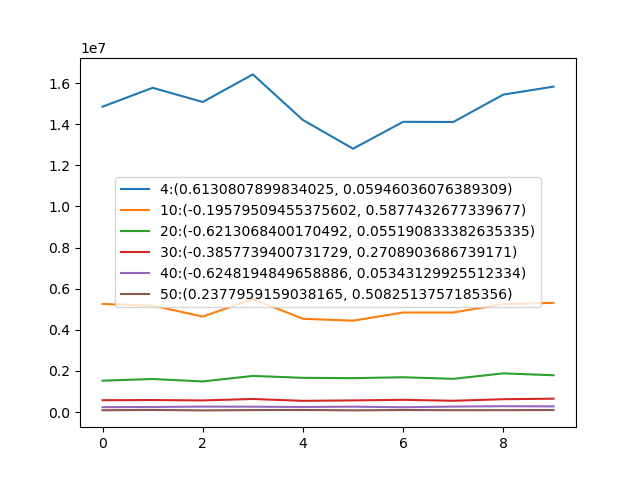

In [8]:
plt.figure()
classes = [i for i in range(10)]
for key, value in paths.items():
    ret = value.abs() # (value-value.mean())/value
    plt.plot(classes, ret.detach().numpy(), label=f'{key}:{pearsonr(ret, acc[key])}')
plt.legend()

In [22]:
pearsonr(ret, acc[key])

(-0.7569172011561116, 0.011255271100047174)